In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os,sys, gc
import keras

dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC,generate_representation
from evaluation import calculate_metrics, evaluate_metadata, evaluate_metadata_raw


folder = "../../KOI_Data/"
folder_lc = "/work/work_teamEXOPLANET/KOI_LC/"

Using TensorFlow backend.


### Folded

In [2]:
### from https://github.com/google-research/exoplanet-ml/blob/master/exoplanet-ml/light_curve/util.py

def phase_fold_time(time, period, t0):
  """Creates a phase-folded time vector.
  result[i] is the unique number in [-period / 2, period / 2)
  such that result[i] = time[i] - t0 + k_i * period, for some integer k_i.
  Args:
    time: 1D numpy array of time values.
    period: A positive real scalar; the period to fold over.
    t0: The center of the resulting folded vector; this value is mapped to 0.
  Returns:
    A 1D numpy array.
  """
  half_period = period / 2
  result = np.mod(time + (half_period - t0), period)
  result -= half_period
  return result

def phase_fold_and_sort_light_curve(time, values, period, t0):
  """Phase folds a light curve and sorts by ascending time.
  Args:
    time: 1D NumPy array of time values.
    values: N-dimensional NumPy array with the same length as time.
    period: A positive real scalar; the period to fold over.
    t0: The center of the resulting folded vector; this value is mapped to 0.
  Returns:
    folded_time: 1D NumPy array of phase folded time values in
        [-period / 2, period / 2), where 0 corresponds to t0 in the original
        time array. Values are sorted in ascending order.
    folded_values: NumPy array. Values are the same as the original values
        array, but sorted by folded_time.
  """
  # Phase fold time.
  time = phase_fold_time(time, period, t0)

  # Sort by ascending time.
  sorted_i = np.argsort(time)
  time = time[sorted_i]
  values = values[sorted_i]

  return time, values

def generate_view(time,
                  values,
                  num_bins,
                  bin_width,
                  t_min,
                  t_max,
                  normalize=True):
  """Generates a view of a phase-folded and binned light curve.
  Args:
    time: 1D NumPy array of time values, sorted in ascending order.
    values: N-dimensional NumPy array with the same length as time.
    num_bins: The number of intervals to divide the time axis into.
    bin_width: The width of each bin on the time axis.
    t_min: The inclusive leftmost value to consider on the time axis.
    t_max: The exclusive rightmost value to consider on the time axis.
    normalize: Whether to center the median at 0 and minimum value at -1.
  Returns:
    NumPy array of length num_bins containing the aggregated values in uniformly
    spaced bins on the phase-folded time axis.
  """
  view, bin_counts = bin_and_aggregate(time, values, num_bins,
                                               bin_width, t_min, t_max)
  # Empty bins fall back to the global median.
  fill_v = np.median(values)
  view = np.where(bin_counts > 0, view, fill_v )
  return view

def global_view(time, values, period, num_bins=2001, bin_width_factor=1 / 2001):
  """Generates a 'global view' of a phase folded light curve.
  See Section 3.3 of Shallue & Vanderburg, 2018, The Astronomical Journal.
  http://iopscience.iop.org/article/10.3847/1538-3881/aa9e09/meta
  Args:
    time: 1D NumPy array of time values, sorted in ascending order.
    values: N-dimensional NumPy array with the same length as time.
    period: The period of the event (in days).
    num_bins: The number of intervals to divide the time axis into.
    bin_width_factor: Width of the bins, as a fraction of period.
  Returns:
    NumPy array of length num_bins containing the aggregated values in uniformly
    spaced bins on the phase-folded time axis.
  """
  return generate_view(
      time,
      values,
      num_bins=num_bins,
      bin_width=period * bin_width_factor,
      t_min=-period / 2,
      t_max=period / 2)


def local_view(time,
               values,
               period,
               duration,
               num_bins=201,
               bin_width_factor=0.16,
               num_durations=4):
  """Generates a 'local view' of a phase folded light curve.
  See Section 3.3 of Shallue & Vanderburg, 2018, The Astronomical Journal.
  http://iopscience.iop.org/article/10.3847/1538-3881/aa9e09/meta
  Args:
    time: 1D NumPy array of time values, sorted in ascending order.
    values: N-dimensional NumPy array with the same length as time.
    period: The period of the event (in days).
    duration: The duration of the event (in days).
    num_bins: The number of intervals to divide the time axis into.
    bin_width_factor: Width of the bins, as a fraction of duration.
    num_durations: The number of durations to consider on either side of 0 (the
      event is assumed to be centered at 0).
  Returns:
    NumPy array of length num_bins containing the aggregated values in uniformly
    spaced bins on the phase-folded time axis.
  """
  return generate_view(
      time,
      values,
      num_bins=num_bins,
      bin_width=duration * bin_width_factor,
      t_min=max(-period / 2, -duration * num_durations),
      t_max=min(period / 2, duration * num_durations))

def bin_and_aggregate(x,
                      y,
                      num_bins,
                      bin_width=None,
                      x_min=None,
                      x_max=None,
                      aggr_fn=None):
  """Aggregates y-values in uniform intervals (bins) along the x-axis.
  The interval [x_min, x_max) is divided into num_bins uniformly spaced
  intervals of width bin_width. The value computed for each bin is the
  aggregation of all y-values whose corresponding x-value is in the interval.
  The default aggregation function is np.median.
  NOTE: x must be sorted in ascending order or the results will be incorrect.
  Args:
    x: 1D NumPy array of x-coordinates sorted in ascending order. Must have at
      least 2 elements, and all elements cannot be the same value.
    y: N-dimensional NumPy array with the same length as x.
    num_bins: The number of intervals to divide the x-axis into. Must be at
      least 2.
    bin_width: The width of each bin on the x-axis. Must be positive, and less
      than x_max - x_min. Defaults to (x_max - x_min) / num_bins.
    x_min: The inclusive leftmost value to consider on the x-axis. Must be less
      than or equal to the largest value of x. Defaults to min(x).
    x_max: The exclusive rightmost value to consider on the x-axis. Must be
      greater than x_min. Defaults to max(x).
    aggr_fn: A function that will be called with signature aggr_fn(y, axis=0) to
      aggregate values within each bin. Default is np.median.
  Returns:
    result: NumPy array of length num_bins containing the aggregated y-values of
      uniformly spaced bins on the x-axis.
    bin_counts: 1D NumPy array of length num_bins indicating the number of
      points in each bin.
  """
  if num_bins < 2:
    raise ValueError("num_bins must be at least 2. Got: {}".format(num_bins))

  # Validate the lengths of x and y.
  x_len = len(x)
  if x_len < 2:
    raise ValueError("len(x) must be at least 2. Got: {}".format(x_len))
  if x_len != len(y):
    raise ValueError("len(x) (got: {}) must equal len(y) (got: {})".format(
        x_len, len(y)))

  # Validate x_min and x_max.
  x_min = x_min if x_min is not None else x[0]
  x_max = x_max if x_max is not None else x[-1]
  if x_min >= x_max:
    raise ValueError("x_min (got: {}) must be less than x_max (got: {})".format(
        x_min, x_max))
  if x_min > x[-1]:
    raise ValueError(
        "x_min (got: {}) must be less than or equal to the largest value of x "
        "(got: {})".format(x_min, x[-1]))

  # Validate bin_width.
  bin_width = bin_width if bin_width is not None else (x_max - x_min) / num_bins
  if bin_width <= 0:
    raise ValueError("bin_width must be positive. Got: {}".format(bin_width))
  if bin_width >= x_max - x_min:
    raise ValueError(
        "bin_width (got: {}) must be less than x_max - x_min (got: {})".format(
            bin_width, x_max - x_min))

  bin_spacing = (x_max - x_min - bin_width) / (num_bins - 1)

  if aggr_fn is None:
    aggr_fn = np.median

  # Initialize output arrays.
  # Ensure default_value is a floating point type, otherwise the aggregated
  # values may unexpectedly be cast to a non-floating type.
  default_dtype = y.dtype if isinstance(y.dtype, np.floating) else np.float
  default_value = np.zeros_like(y[0], dtype=default_dtype)
  result = np.repeat([default_value], num_bins, axis=0)
  bin_counts = np.zeros(num_bins, dtype=np.int)

  # Find the first element of x >= x_min. This loop is guaranteed to produce
  # a valid index because we know that x_min <= x[-1].
  x_start = 0
  while x[x_start] < x_min:
    x_start += 1

  # The bin at index i is the aggregation of all elements y[j] such that
  # bin_min <= x[j] < bin_max, where bin_min and bin_max are the endpoints of
  # bin i.
  bin_min = x_min  # Left endpoint of the current bin.
  bin_max = x_min + bin_width  # Right endpoint of the current bin.
  j_start = x_start  # Inclusive left index of the current bin.
  j_end = x_start  # Exclusive end index of the current bin.

  for i in range(num_bins):
    # Move j_start to the first index of x >= bin_min.
    while j_start < x_len and x[j_start] < bin_min:
      j_start += 1

    # Move j_end to the first index of x >= bin_max (exclusive end index).
    while j_end < x_len and x[j_end] < bin_max:
      j_end += 1

    if j_end > j_start:
      # Compute and insert the aggregate y value in the bin.
      result[i] = aggr_fn(y[j_start:j_end], axis=0)
      bin_counts[i] = j_end - j_start

    # Advance the bin.
    bin_min += bin_spacing
    bin_max += bin_spacing

  return result, bin_counts

### Create dataset

In [260]:
def generate_sin(N=10000, sigma =1):
    per = np.random.uniform(0.1, 100)
    t0 = np.random.uniform(0.1, per*0.5)
    T_n = np.random.exponential(5)
        
    sigma = per*0.1 #np.min([per*0.1, sigma])
    
    t = np.linspace(0, T_n*per, N) +np.random.normal(0, scale=sigma, size=N) #np.minimum(dif_0, np.maximum(-dif_0 , np.random.normal(0,scale=1, size=N) ))
    
    t += np.abs(t.min())
    t = np.sort(t)
    
    data = 3.0*np.sin(2*np.pi*t/per + t0) + np.random.randn(N) # create artificial data with noise
    
    return t, data, per, t0

In [265]:
t, data, per, t0 = generate_sin(200)

In [266]:
np.diff(t)

array([5.23061155e-01, 3.54440597e-02, 1.67347491e-01, 2.38794157e-01,
       6.91316880e-02, 1.35193847e-02, 2.72003567e-01, 5.09911132e-02,
       8.52173653e-02, 4.57661376e-02, 4.34519290e-02, 5.47239392e-02,
       5.22268469e-02, 3.66982633e-02, 4.83430111e-02, 2.63212021e-02,
       8.94657754e-03, 3.66577617e-03, 3.99398313e-02, 1.41163497e-01,
       1.72484344e-03, 4.31179658e-02, 1.17543639e-02, 1.31763160e-02,
       4.14005189e-02, 6.01572896e-02, 7.25741852e-02, 3.79798724e-02,
       3.01572065e-02, 2.37246857e-03, 4.88677290e-02, 2.62957815e-02,
       6.73219391e-02, 2.20219845e-02, 3.10702190e-02, 5.29613574e-02,
       2.30042765e-03, 3.70033418e-02, 1.40836850e-01, 2.28566568e-02,
       1.81921662e-01, 9.23939066e-04, 1.05615928e-01, 3.98469036e-02,
       1.07613652e-01, 1.77845431e-02, 2.78537271e-02, 2.70785705e-02,
       3.93246963e-02, 7.74647109e-05, 3.09144836e-02, 5.86173056e-02,
       2.20119268e-02, 8.85547510e-03, 5.20485167e-02, 3.24904764e-02,
      

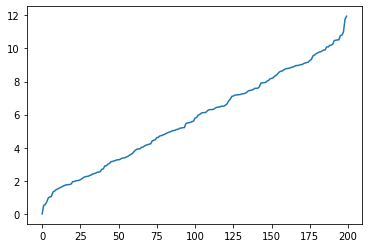

In [267]:
plt.plot(t)

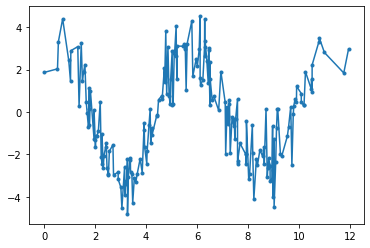

In [268]:
plt.plot(t,data, '.-')

In [19]:
t_fold, val_fold = phase_fold_and_sort_light_curve(t, data, period= per, t0= t0)

val_glo = global_view(t_fold, val_fold, period=per, num_bins=T, bin_width_factor=1 / T)

In [23]:
t_fold

array([-41.20989909, -41.20765773, -41.20541636, -41.203175  ,
       -39.4501232 , -39.44788184, -39.44564047, -39.44339911,
       -37.69034731, -37.68810595, -37.68586458, -37.68362322,
       -35.93057142, -35.92833006, -35.92608869, -35.92384733,
       -34.17079553, -34.16855417, -34.1663128 , -34.16407144,
       -32.41101964, -32.40877828, -32.40653691, -32.40429555,
       -30.65124375, -30.64900239, -30.64676102, -30.64451966,
       -28.89146786, -28.8892265 , -28.88698513, -28.88474377,
       -27.13169197, -27.12945061, -27.12720924, -27.12496788,
       -25.37191608, -25.36967472, -25.36743335, -25.36519199,
       -23.61214019, -23.60989883, -23.60765747, -23.6054161 ,
       -21.8523643 , -21.85012294, -21.84788158, -21.84564021,
       -20.09482978, -20.09258841, -20.09034705, -20.08810569,
       -20.08586432, -18.33505389, -18.33281252, -18.33057116,
       -18.3283298 , -18.32608843, -16.575278  , -16.57303663,
       -16.57079527, -16.56855391, -16.56631254, -14.81

In [22]:
np.diff(t_fold)

array([0.00224136, 0.00224136, 0.00224136, 1.7530518 , 0.00224136,
       0.00224136, 0.00224136, 1.7530518 , 0.00224136, 0.00224136,
       0.00224136, 1.7530518 , 0.00224136, 0.00224136, 0.00224136,
       1.7530518 , 0.00224136, 0.00224136, 0.00224136, 1.7530518 ,
       0.00224136, 0.00224136, 0.00224136, 1.7530518 , 0.00224136,
       0.00224136, 0.00224136, 1.7530518 , 0.00224136, 0.00224136,
       0.00224136, 1.7530518 , 0.00224136, 0.00224136, 0.00224136,
       1.7530518 , 0.00224136, 0.00224136, 0.00224136, 1.7530518 ,
       0.00224136, 0.00224136, 0.00224136, 1.7530518 , 0.00224136,
       0.00224136, 0.00224136, 1.75081044, 0.00224136, 0.00224136,
       0.00224136, 0.00224136, 1.75081044, 0.00224136, 0.00224136,
       0.00224136, 0.00224136, 1.75081044, 0.00224136, 0.00224136,
       0.00224136, 0.00224136, 1.75081044, 0.00224136, 0.00224136,
       0.00224136, 0.00224136, 1.75081044, 0.00224136, 0.00224136,
       0.00224136, 0.00224136, 1.75081044, 0.00224136, 0.00224

In [269]:
T = 200

In [270]:
X_fold_lc = []
X_fold_time = []

N_d = 10000
for n in range(N_d):
    if n%500 == 0:
        print("Va en el, ",n)
    t, y, per, t0 = generate_sin(T) #que genere 200 

    t_fold, val_fold = phase_fold_and_sort_light_curve(t, y, period= per, t0= t0)

    #val_glo = global_view(t_fold, val_fold, period=per, num_bins=T, bin_width_factor=1 / T)
    val_glo = val_fold
    
    #preprocess global..
    val_glo = val_glo- np.nanmean(val_glo, axis=-1, keepdims=True)
    val_glo = val_glo/(np.nanstd(val_glo, axis=-1, keepdims=True)+1e-8)
    
    X_fold_lc.append(val_glo)
    
    #t_glo_diff = np.concatenate([[0], np.tile(per/T, T-1)])
    t_glo_diff = t_fold
    X_fold_time.append(t_glo_diff) #differences values
    
X_fold_lc = np.asarray(X_fold_lc)
X_fold_time = np.asarray(X_fold_time)
X_fold_lc.shape

Va en el,  0
Va en el,  500
Va en el,  1000
Va en el,  1500
Va en el,  2000
Va en el,  2500
Va en el,  3000
Va en el,  3500
Va en el,  4000
Va en el,  4500
Va en el,  5000
Va en el,  5500
Va en el,  6000
Va en el,  6500
Va en el,  7000
Va en el,  7500
Va en el,  8000
Va en el,  8500
Va en el,  9000
Va en el,  9500


(10000, 200)

In [271]:
mask_train = np.random.rand(N_d) < 0.7


X_train = X_fold_lc[mask_train]
X_train_t = X_fold_time[mask_train]

X_test = X_fold_lc[~mask_train]
X_test_t = X_fold_time[~mask_train]

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

X_train_t = np.expand_dims(X_train_t, axis=-1)
X_test_t = np.expand_dims(X_test_t, axis=-1)

print("X train shape: ",X_train.shape)
print("X train time shape: ",X_train_t.shape)
print("X test shape: ",X_test.shape)

X train shape:  (7016, 200, 1)
X train time shape:  (7016, 200, 1)
X test shape:  (2984, 200, 1)


### Keras models

In [281]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import *

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
def plot_n_lc(real_lc, decoded_lc, n = 10):
    for _ in range(n):
        n_sampled = np.random.randint(0, real_lc.shape[0])
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize= (15,5))
        ax1.plot(real_lc[n_sampled], 'b.-')
        ax1.set_title("Real")
        ax2.plot(decoded_lc[n_sampled], 'b.-')
        ax2.set_title("Reconstructed")
        plt.show()  

        plt.figure(figsize=(15,5))
        plt.plot(real_lc[n_sampled], 'bo-', label="Real")
        plt.plot(decoded_lc[n_sampled], 'g*-', label="Reconstructed")
        plt.title("Over")
        plt.legend()
        plt.show()
        print("----------------------------------------------------------------")

In [282]:
latent_dim = 16
T, channels = X_train.shape[1:]
D_dim = 5 #o variar: Period", "Duration", "Time of Transit Epoch", "r/R", "a/R",

### Regular AE

## Regular VAE

In [283]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon


def KL_loss(y_true, y_pred):
    return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

def recon_loss(y_true, y_pred):
    return K.mean( K.square( K.squeeze(y_true, axis=-1) - K.squeeze(y_pred, axis=-1) ), axis=-1) #SSE

def vae_loss(y_true, y_pred):
    return recon_loss(y_true, y_pred) + KL_loss(y_true, y_pred)

In [284]:
x = Input(shape = (T, channels) )

f1 = GRU(64, return_sequences=True)(x) #bidirectional
f1 = GRU(64, return_sequences=False)(f1) #bidirectional

#f1 = Dense(128, activation='relu')(f1) #sacar?

z_mean = Dense(latent_dim,activation='linear')(f1)
z_log_var = Dense(latent_dim,activation='linear')(f1)
encoder = Model(x, z_mean, name="encoder")



z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model(x, z, name="encoder_sampling")
samp_encoder.summary()

Model: "encoder_sampling"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 200, 1)       0                                            
__________________________________________________________________________________________________
gru_9 (GRU)                     (None, 200, 64)      12672       input_4[0][0]                    
__________________________________________________________________________________________________
gru_10 (GRU)                    (None, 64)           24768       gru_9[0][0]                      
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 16)           1040        gru_10[0][0]                     
___________________________________________________________________________________

In [285]:
decoder_input = Input(shape=(latent_dim,))
#decoder_hid = Dense(128, activation='relu') #pasara encode

decode = RepeatVector(T)(decoder_input)

decode = GRU(64, return_sequences=True)(decode) #bidirectional
decode = GRU(64, return_sequences=True)(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model(decoder_input, decode, name="generator")
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 16)                0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 200, 16)           0         
_________________________________________________________________
gru_11 (GRU)                 (None, 200, 64)           15552     
_________________________________________________________________
gru_12 (GRU)                 (None, 200, 64)           24768     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 200, 1)            65        
Total params: 40,385
Trainable params: 40,385
Non-trainable params: 0
_________________________________________________________________


In [286]:
# instantiate VAE model
out = generator(samp_encoder(x))
vae = Model(x, out)

vae.compile(optimizer='adam', loss=vae_loss, metrics = [KL_loss, recon_loss])
vae.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 200, 1)            0         
_________________________________________________________________
encoder_sampling (Model)     (None, 16)                39520     
_________________________________________________________________
generator (Model)            (None, 200, 1)            40385     
Total params: 79,905
Trainable params: 79,905
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x = Input(shape = (T, channels) )

f1 = GRU(64, return_sequences=True)(x) #bidirectional
f1 = GRU(64, return_sequences=False)(f1) #bidirectional

z_mean = Dense(latent_dim,activation='linear')(f1)
z_log_var = Dense(latent_dim,activation='linear')(f1)
encoder = Model(x, z_mean, name="encoder")
z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model(x, z, name="encoder_sampling")

decoder_input = Input(shape=(latent_dim,))

decode = RepeatVector(T)(decoder_input)

decode = GRU(64, return_sequences=True)(decode) #bidirectional
decode = GRU(64, return_sequences=True)(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model(decoder_input, decode, name="generator")

# instantiate VAE model
out = generator(samp_encoder(x))
vae = Model(x, out)
vae.compile(optimizer='adam', loss=vae_loss, metrics = [KL_loss, recon_loss])
vae.summary()

batch_size = 64
vae.fit(X_train, X_train, epochs=20, batch_size=batch_size, validation_data=(X_test, X_test))

In [ ]:
X_train_hat = vae.predict(X_train, batch_size=512)
plot_n_lc(X_train, X_train_hat, n= 10)

In [ ]:
x = Input(shape = (T, channels) )

f1 = Bidirectional(GRU(64, return_sequences=True))(x) #bidirectional
f1 = Bidirectional(GRU(64, return_sequences=False))(f1) #bidirectional

z_mean = Dense(latent_dim,activation='linear')(f1)
z_log_var = Dense(latent_dim,activation='linear')(f1)
encoder = Model(x, z_mean, name="encoder")
z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model(x, z, name="encoder_sampling")

decoder_input = Input(shape=(latent_dim,))

decode = RepeatVector(T)(decoder_input)

decode = Bidirectional(GRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(GRU(64, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model(decoder_input, decode, name="generator")

# instantiate VAE model
out = generator(samp_encoder(x))
vae = Model(x, out)
vae.compile(optimizer='adam', loss=vae_loss, metrics = [KL_loss, recon_loss])
vae.summary()

batch_size = 64
vae.fit(X_train, X_train, epochs=20, batch_size=batch_size, validation_data=(X_test, X_test))

In [ ]:
X_train_hat = vae.predict(X_train, batch_size=512)
plot_n_lc(X_train, X_train_hat, n= 10)

### Con tiempo, asimilando la arquitectura de Naul

In [287]:
x_lc = Input(shape = (T, channels) , name="LC_inp")
x_t = Input(shape = (T, channels) , name ="T_inp")

x = Concatenate(axis=-1)([x_t, x_lc]) #add time encode

f1 = Bidirectional(GRU(64, return_sequences=True))(x) #bidirectional
f1 = Bidirectional(GRU(64, return_sequences=False))(f1) #bidirectional

z_mean = Dense(latent_dim,activation='linear')(f1)
z_log_var = Dense(latent_dim,activation='linear')(f1)
encoder = Model([x_t, x_lc], z_mean, name="encoder")
z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model([x_t, x_lc], z, name="encoder_sampling")

decoder_input = Input(shape=(latent_dim,))

decode = RepeatVector(T)(decoder_input)

decode = Concatenate(axis=-1)([x_t, decode]) #add time decode

decode = Bidirectional(GRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(GRU(64, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model([x_t, decoder_input], decode, name="generator")

# instantiate VAE model
out = generator([x_t, samp_encoder([x_t, x_lc]) ])
vae = Model([x_t, x_lc], out)
vae.compile(optimizer='adam', loss=vae_loss, metrics = [KL_loss, recon_loss])
vae.summary()

batch_size = 128
vae.fit([X_train_t,X_train], X_train, epochs=40, batch_size=batch_size, 
        validation_data=([X_test_t,X_test], X_test))

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T_inp (InputLayer)              (None, 200, 1)       0                                            
__________________________________________________________________________________________________
LC_inp (InputLayer)             (None, 200, 1)       0                                            
__________________________________________________________________________________________________
encoder_sampling (Model)        (None, 16)           103968      T_inp[0][0]                      
                                                                 LC_inp[0][0]                     
__________________________________________________________________________________________________
generator (Model)               (None, 200, 1)       105729      T_inp[0][0]                

7016/7016 [==============================] - 201s 29ms/step - loss: 1.0007 - KL_loss: 7.5399e-04 - recon_loss: 0.9999 - val_loss: 1.0104 - val_KL_loss: 5.0616e-04 - val_recon_loss: 1.0099
Epoch 36/40
7016/7016 [==============================] - 201s 29ms/step - loss: 1.0031 - KL_loss: 5.4682e-04 - recon_loss: 1.0025 - val_loss: 1.0079 - val_KL_loss: 6.0297e-04 - val_recon_loss: 1.0073
Epoch 37/40
7016/7016 [==============================] - 201s 29ms/step - loss: 1.0020 - KL_loss: 5.7334e-04 - recon_loss: 1.0014 - val_loss: 1.0021 - val_KL_loss: 4.7994e-04 - val_recon_loss: 1.0016
Epoch 38/40
7016/7016 [==============================] - 202s 29ms/step - loss: 1.0008 - KL_loss: 5.2286e-04 - recon_loss: 1.0003 - val_loss: 1.0162 - val_KL_loss: 4.2607e-04 - val_recon_loss: 1.0158
Epoch 39/40
7016/7016 [==============================] - 202s 29ms/step - loss: 1.0010 - KL_loss: 6.3262e-04 - recon_loss: 1.0004 - val_loss: 0.9982 - val_KL_loss: 4.4571e-04 - val_recon_loss: 0.9977
Epoch 40/40


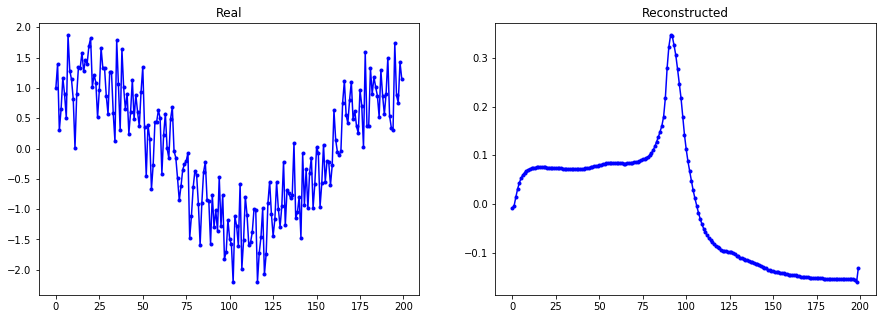

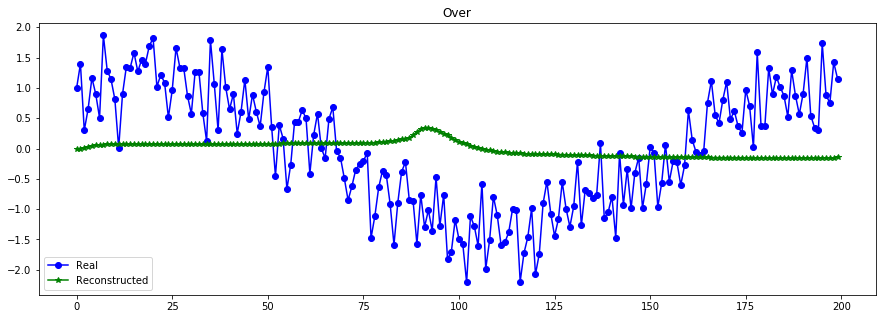

----------------------------------------------------------------


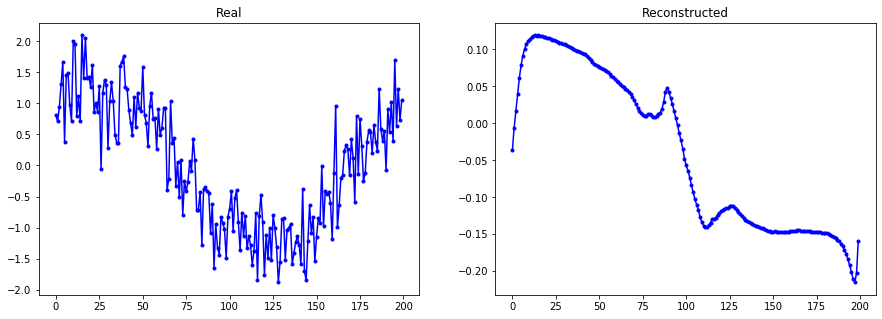

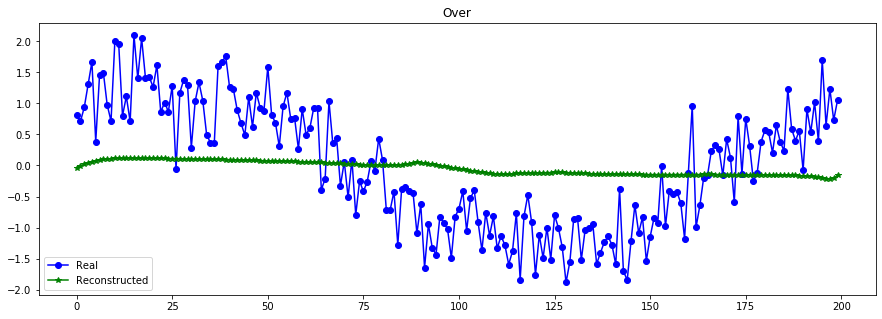

----------------------------------------------------------------


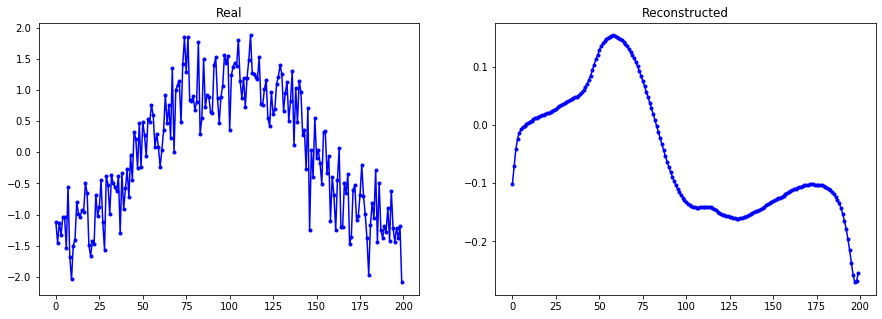

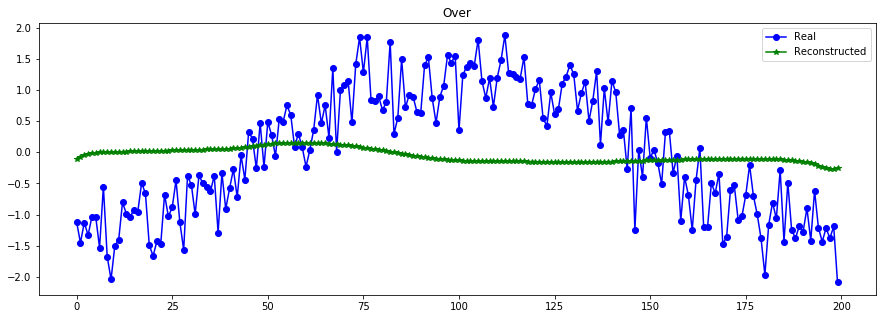

----------------------------------------------------------------


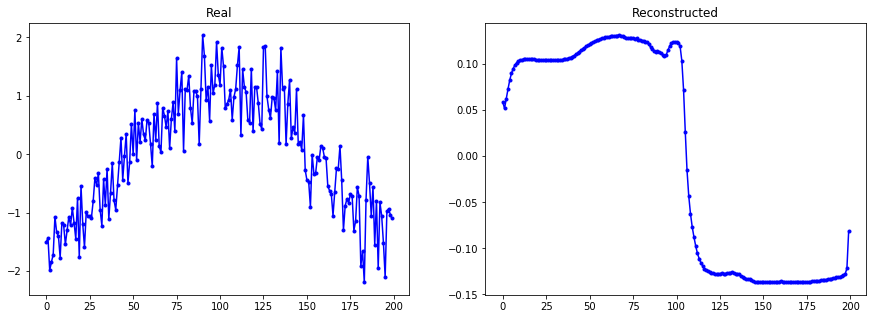

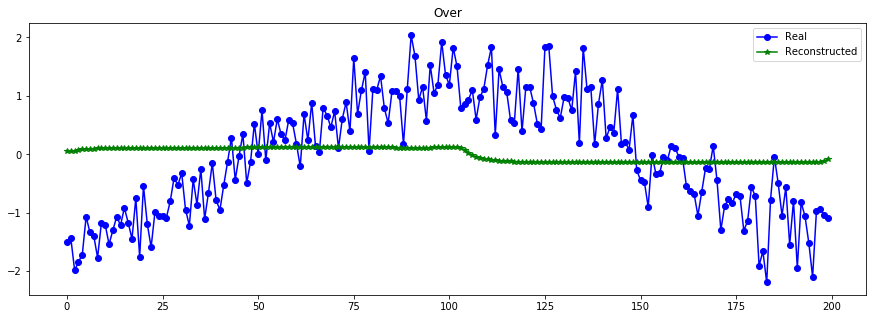

----------------------------------------------------------------


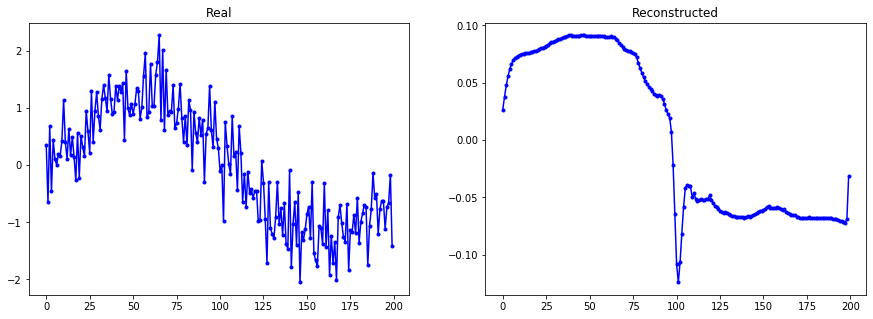

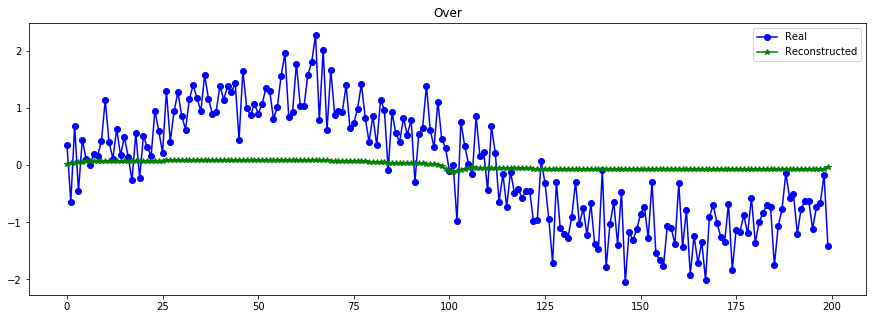

----------------------------------------------------------------


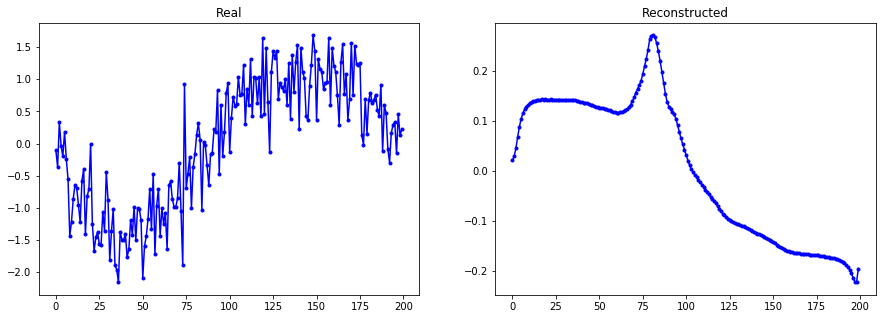

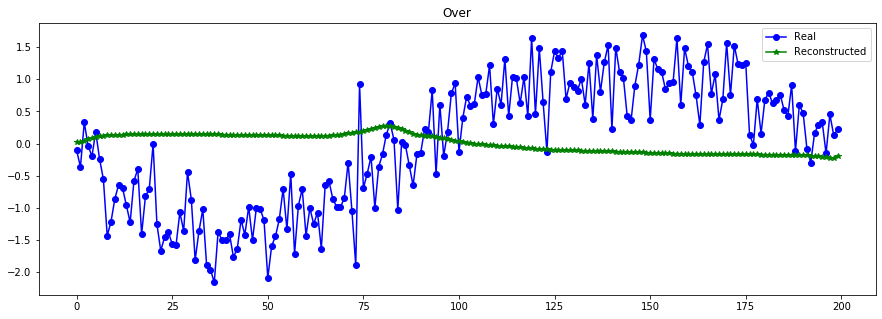

----------------------------------------------------------------


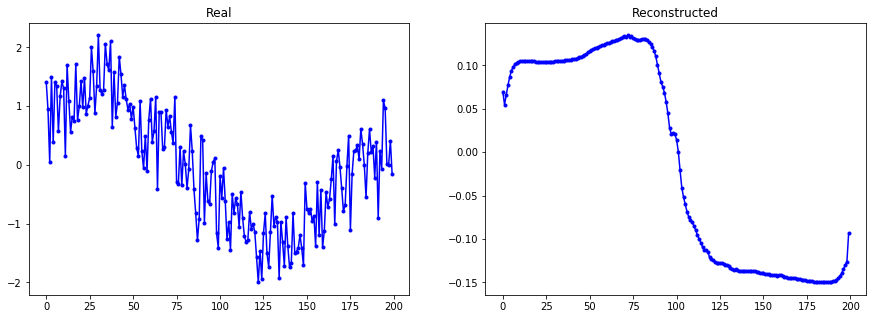

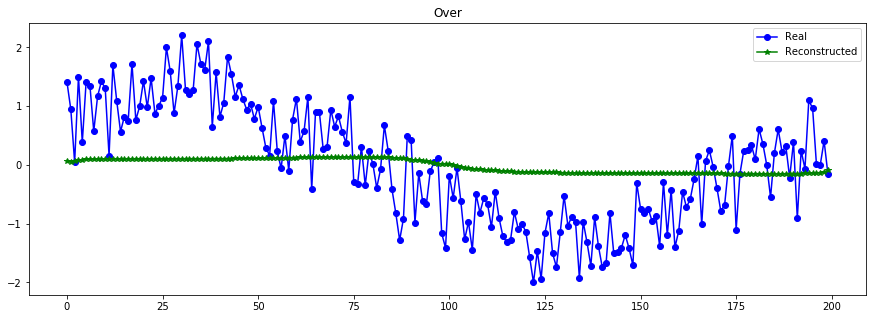

----------------------------------------------------------------


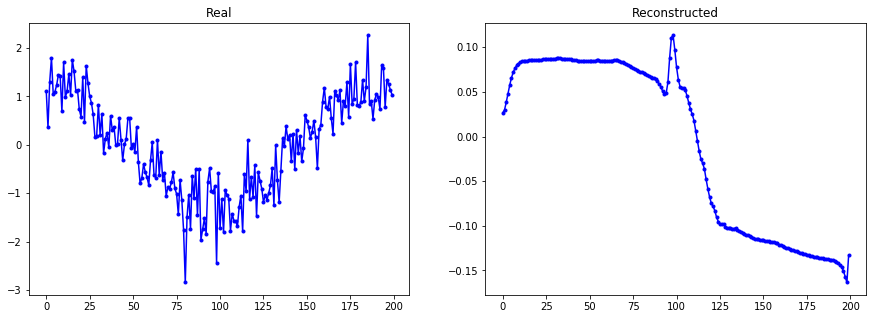

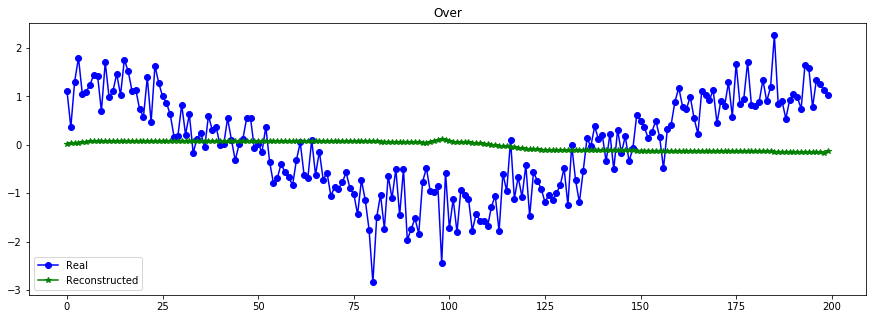

----------------------------------------------------------------


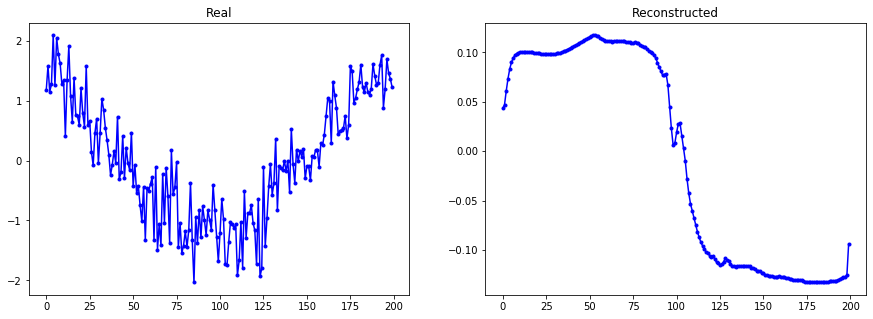

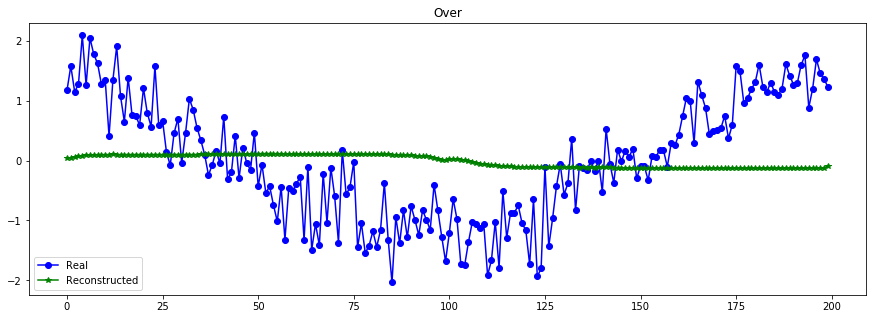

----------------------------------------------------------------


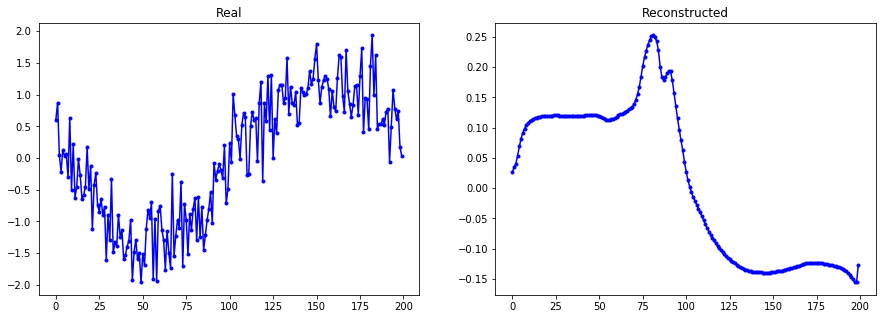

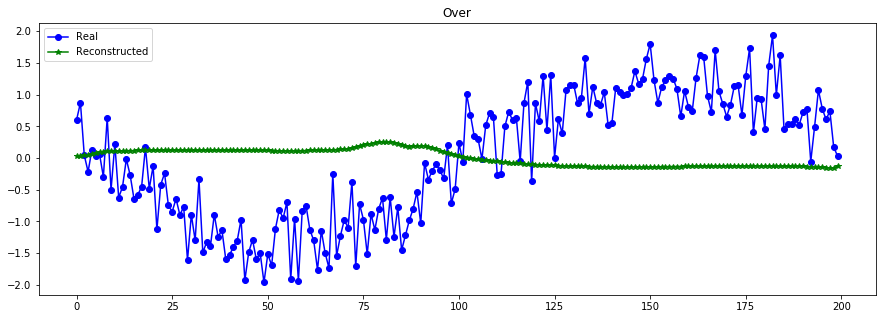

----------------------------------------------------------------


In [288]:
X_train_hat = vae.predict([X_train_t,X_train], batch_size=512)
plot_n_lc(X_train, X_train_hat, n= 10)

In [ ]:
keras.optimizers.Adam(learning_rate=5e-4) #naul
keras.optimizers.Adam(learning_rate=2e-4) #tsang
notroso 1e-3 == 0.001
#dropa de 0.25
#tsamg baja embedd a 16
#todos con epochs > 100

In [22]:
x_lc = Input(shape = (T, channels) , name="LC_inp")
x_t = Input(shape = (T, channels) , name ="T_inp")

x = Concatenate(axis=-1)([x_t, x_lc]) #add time encode

f1 = Bidirectional(GRU(96, return_sequences=True))(x) #bidirectional
f1 = Bidirectional(GRU(96, return_sequences=False))(f1) #bidirectional

z_mean = Dense(latent_dim,activation='linear')(f1)
z_log_var = Dense(latent_dim,activation='linear')(f1)
encoder = Model([x_t, x_lc], z_mean, name="encoder")
z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model([x_t, x_lc], z, name="encoder_sampling")

decoder_input = Input(shape=(latent_dim,))

decode = RepeatVector(T)(decoder_input)

decode = Concatenate(axis=-1)([x_t, decode]) #add time decode

decode = Bidirectional(GRU(96, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(GRU(96, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model([x_t, decoder_input], decode, name="generator")

# instantiate VAE model
out = generator([x_t, samp_encoder([x_t, x_lc]) ])
vae = Model([x_t, x_lc], out)
vae.compile(optimizer=keras.optimizers.Adam(lr=5e-4), loss=vae_loss, metrics = [KL_loss, recon_loss])
vae.summary()

batch_size = 64
vae.fit([X_train_t,X_train], X_train, epochs=50, batch_size=batch_size, 
        validation_data=([X_test_t,X_test], X_test))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T_inp (InputLayer)              (None, 200, 1)       0                                            
__________________________________________________________________________________________________
LC_inp (InputLayer)             (None, 200, 1)       0                                            
__________________________________________________________________________________________________
encoder_sampling (Model)        (None, 64)           248192      T_inp[0][0]                      
                                                                 LC_inp[0][0]                     
__________________________________________________________________________________________________
generator (Model)               (None, 200, 1)       259969      T_inp[0][0]                

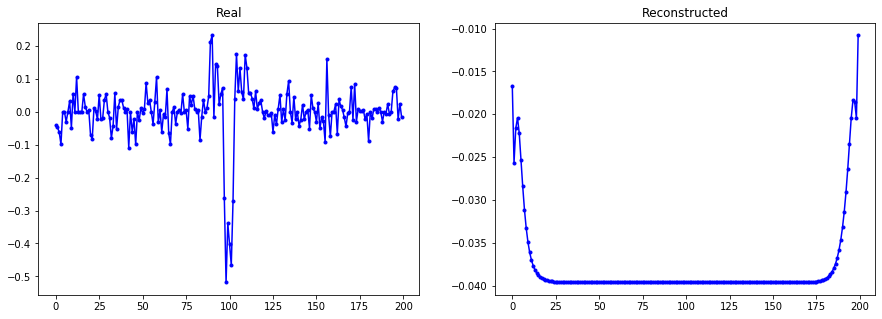

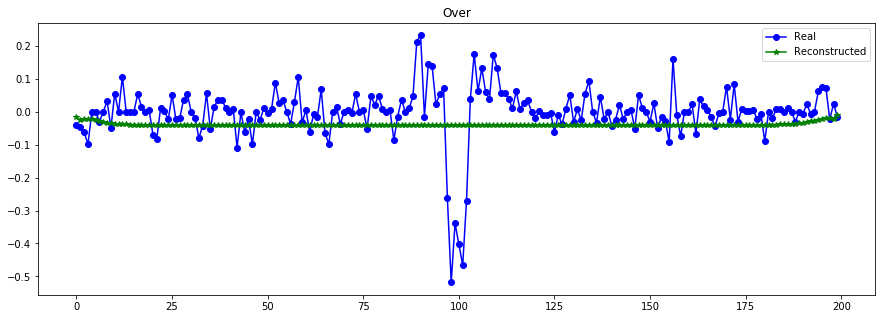

----------------------------------------------------------------


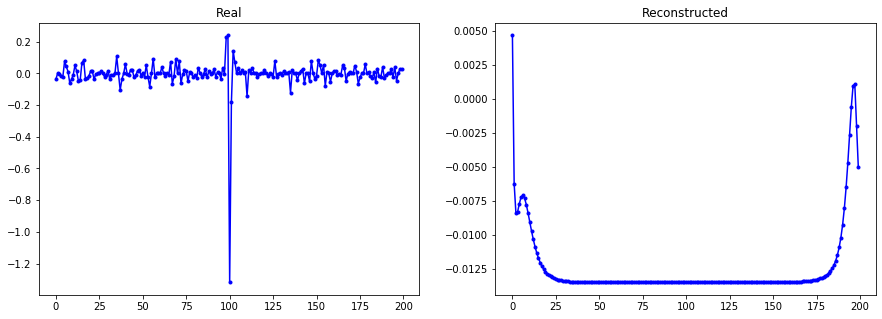

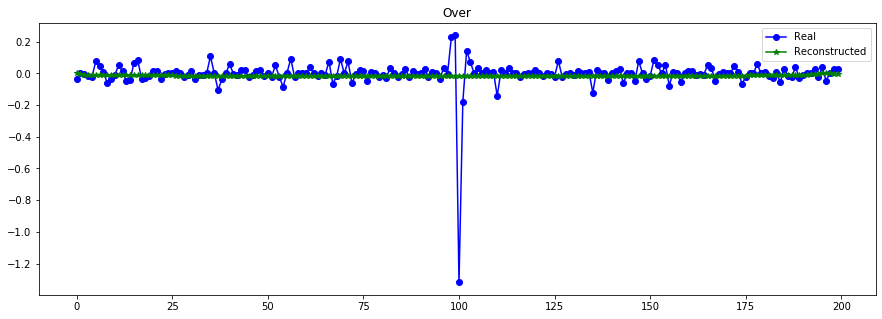

----------------------------------------------------------------


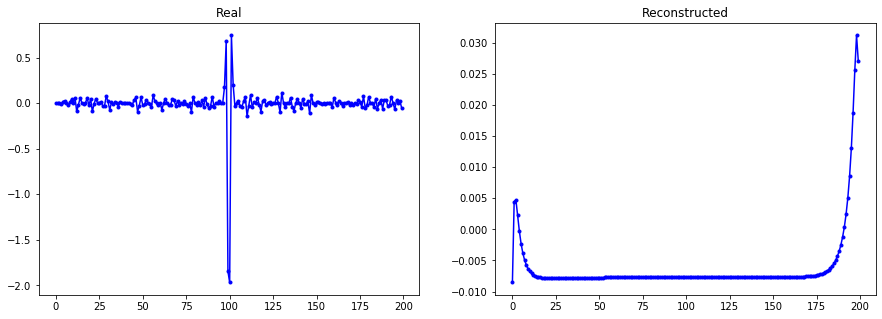

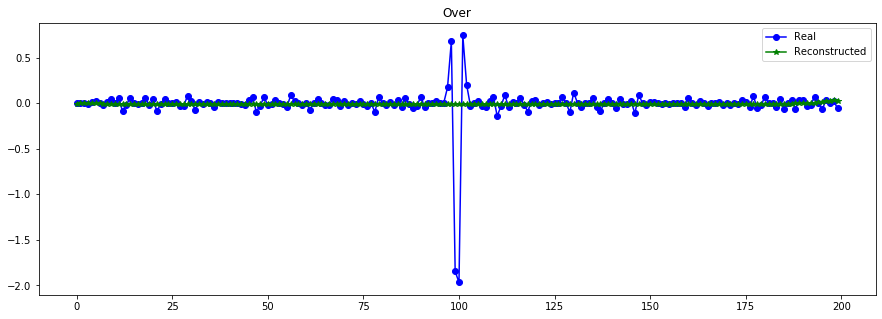

----------------------------------------------------------------


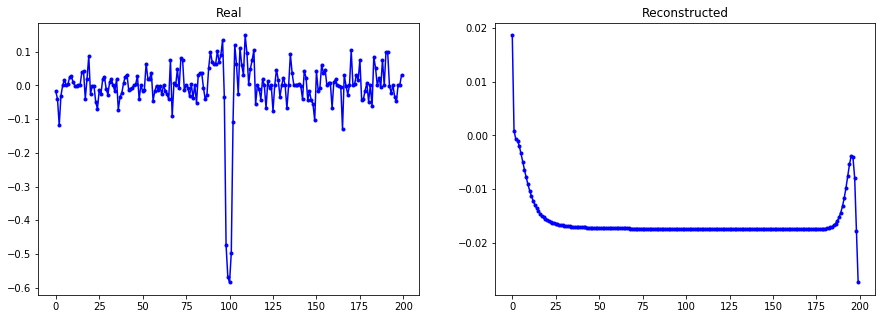

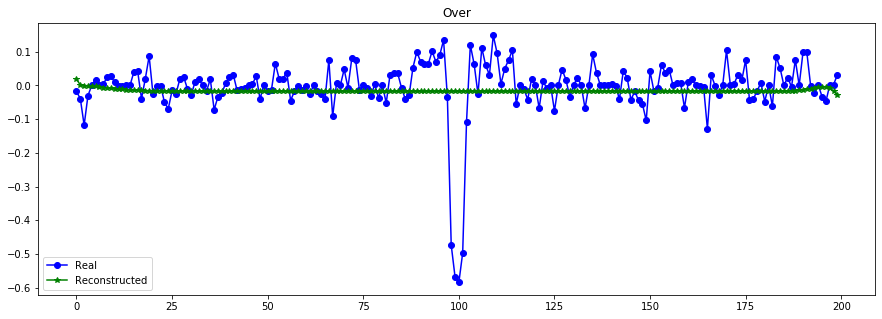

----------------------------------------------------------------


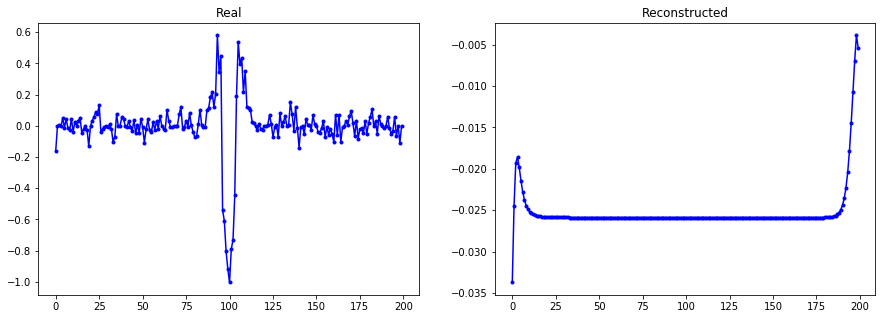

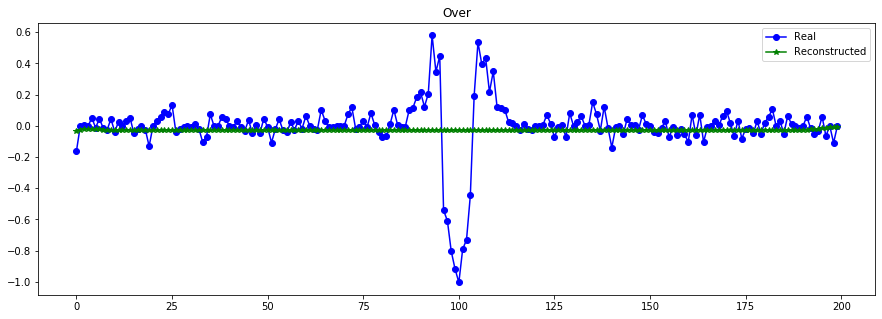

----------------------------------------------------------------


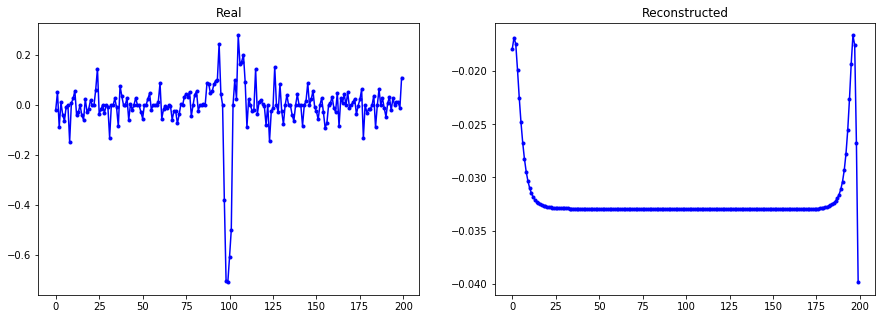

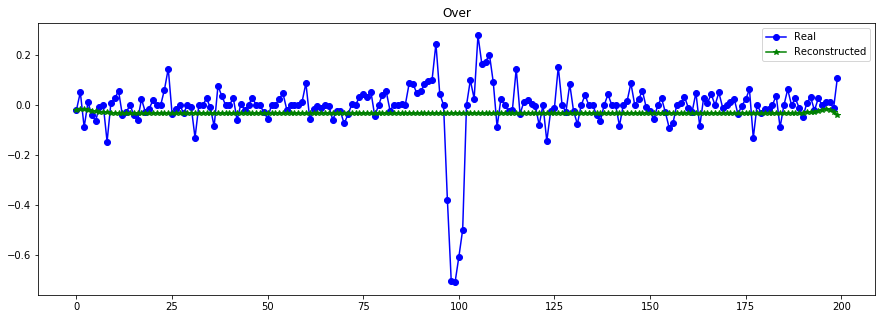

----------------------------------------------------------------


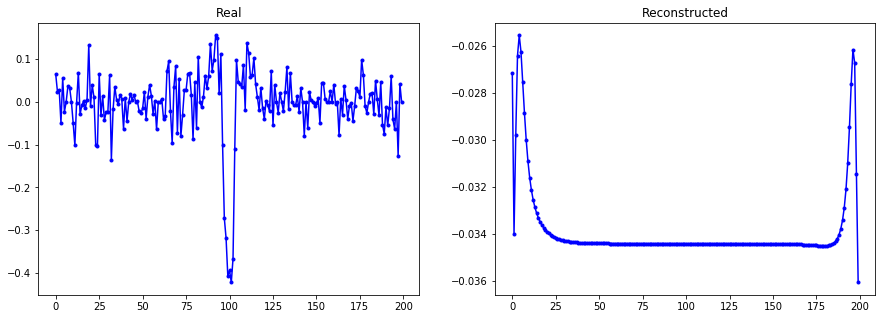

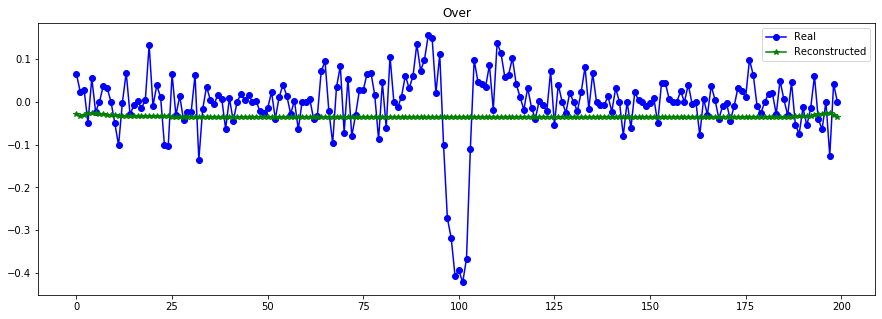

----------------------------------------------------------------


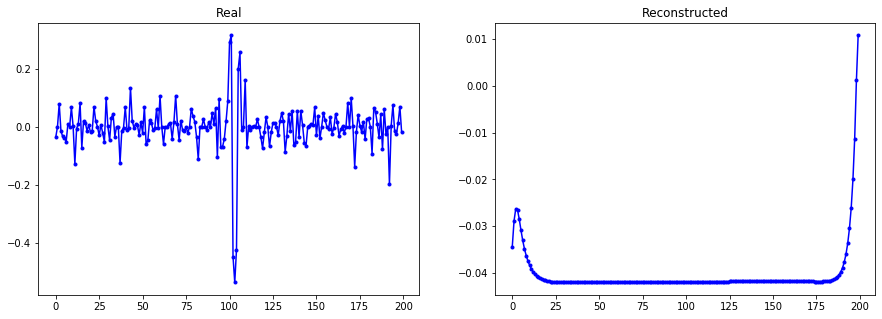

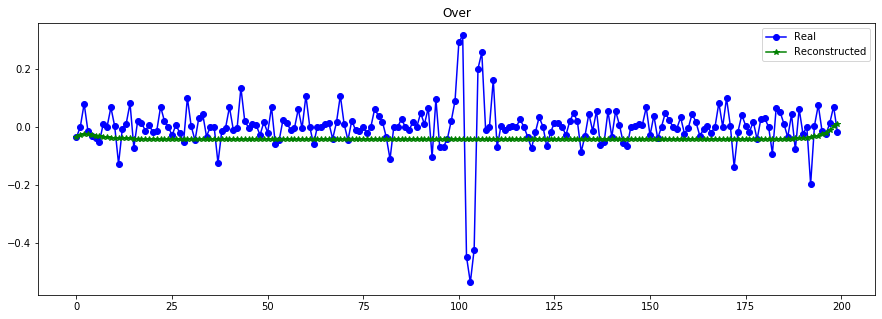

----------------------------------------------------------------


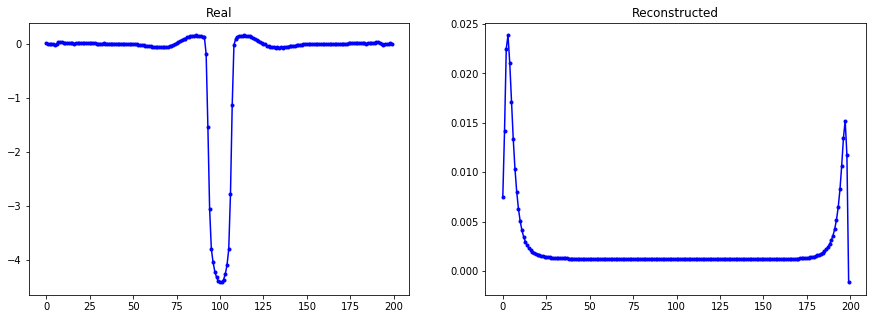

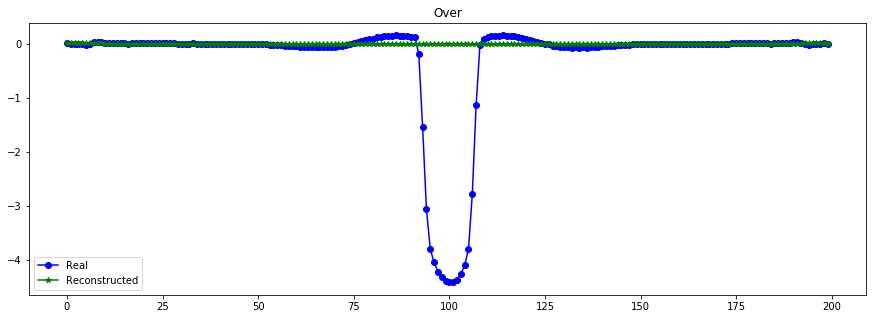

----------------------------------------------------------------


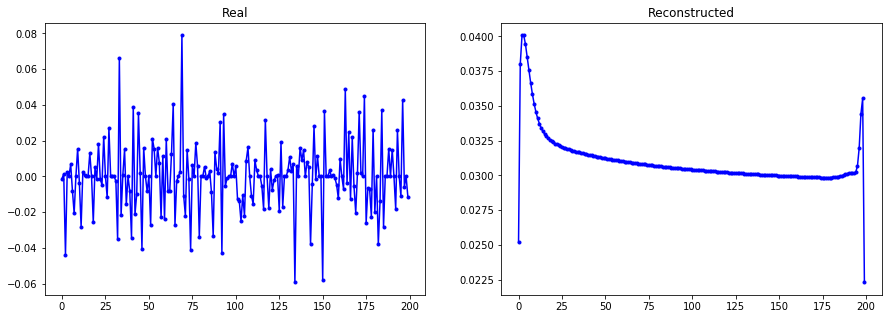

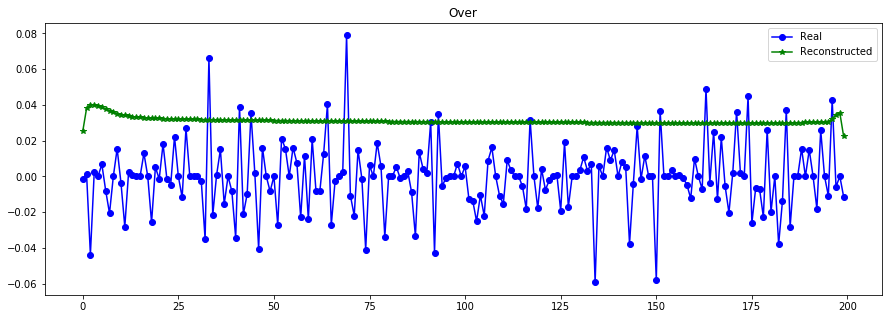

----------------------------------------------------------------


In [23]:
X_train_hat = vae.predict([X_train_t,X_train], batch_size=512)
plot_n_lc(X_train, X_train_hat, n= 10)

{'whiskers': [<matplotlib.lines.Line2D at 0x2aed7f739a58>,
 'caps': [<matplotlib.lines.Line2D at 0x2aededb51a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x2aededb41f98>],
 'medians': [<matplotlib.lines.Line2D at 0x2aededb51e80>],
 'fliers': [<matplotlib.lines.Line2D at 0x2aededb51f60>],
 'means': []}

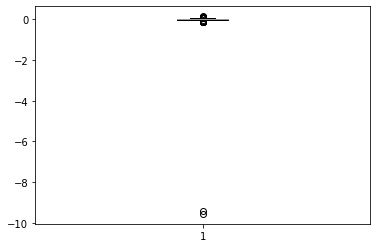

In [24]:
plt.boxplot(X_train[0,:,0])

In [22]:
#https://towardsdatascience.com/deep-quantile-regression-c85481548b5a
#https://arxiv.org/pdf/1808.08798.pdf
def vae_titled_loss(q):
    def loss(y_true, y_pred):
        e = K.squeeze(y_true, axis=-1) - K.squeeze(y_pred, axis=-1) #residuals
        return K.mean( K.maximum(q*e, (q-1)*e), axis=-1) + KL_loss(y_true,y_pred) #mean
    return loss

In [23]:
x_lc = Input(shape = (T, channels) , name="LC_inp")
x_t = Input(shape = (T, channels) , name ="T_inp")

x = Concatenate(axis=-1)([x_t, x_lc]) #add time encode

f1 = Bidirectional(GRU(96, return_sequences=True))(x) #bidirectional
f1 = Bidirectional(GRU(96, return_sequences=False))(f1) #bidirectional

z_mean = Dense(latent_dim,activation='linear')(f1)
z_log_var = Dense(latent_dim,activation='linear')(f1)
encoder = Model([x_t, x_lc], z_mean, name="encoder")
z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model([x_t, x_lc], z, name="encoder_sampling")

decoder_input = Input(shape=(latent_dim,))

decode = RepeatVector(T)(decoder_input)

decode = Concatenate(axis=-1)([x_t, decode]) #add time decode

decode = Bidirectional(GRU(96, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(GRU(96, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model([x_t, decoder_input], decode, name="generator")

# instantiate VAE model
out = generator([x_t, samp_encoder([x_t, x_lc]) ])
vae = Model([x_t, x_lc], out)

vae.compile(optimizer='adam', loss=vae_titled_loss(0.1), metrics = [KL_loss, recon_loss])

vae.summary()

batch_size = 64
vae.fit([X_train_t,X_train], X_train, epochs=50, batch_size=batch_size, 
        validation_data=([X_test_t,X_test], X_test))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T_inp (InputLayer)              (None, 200, 1)       0                                            
__________________________________________________________________________________________________
LC_inp (InputLayer)             (None, 200, 1)       0                                            
__________________________________________________________________________________________________
encoder_sampling (Model)        (None, 64)           248192      T_inp[0][0]                      
                                                                 LC_inp[0][0]                     
__________________________________________________________________________________________________
generator (Model)               (None, 200, 1)       259969      T_inp[0][0]                

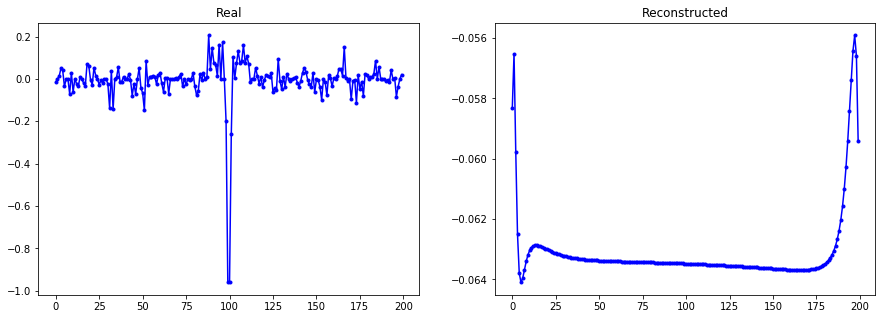

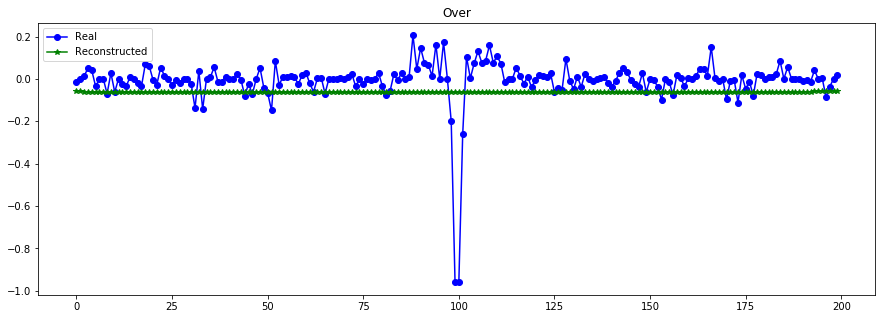

----------------------------------------------------------------


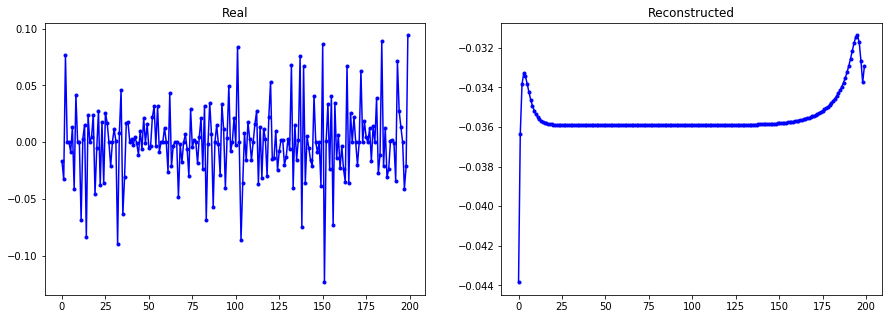

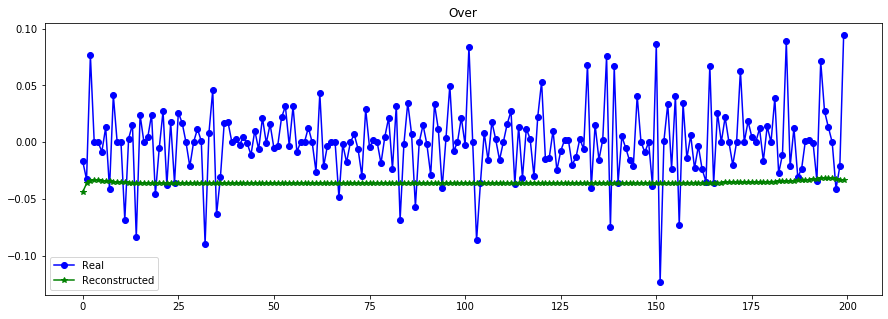

----------------------------------------------------------------


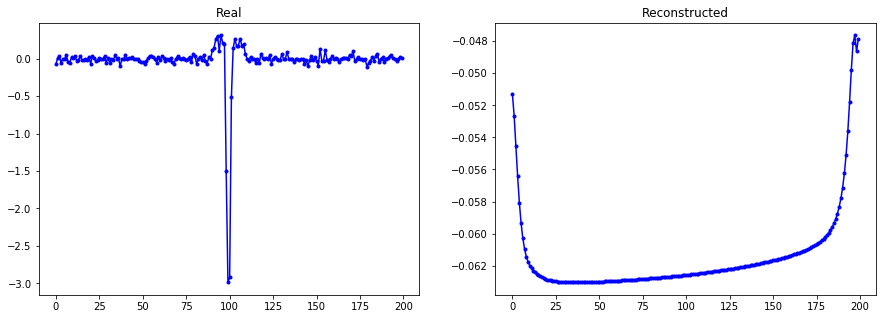

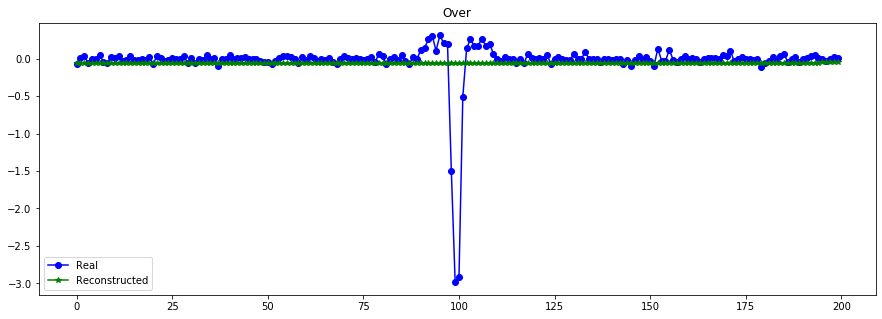

----------------------------------------------------------------


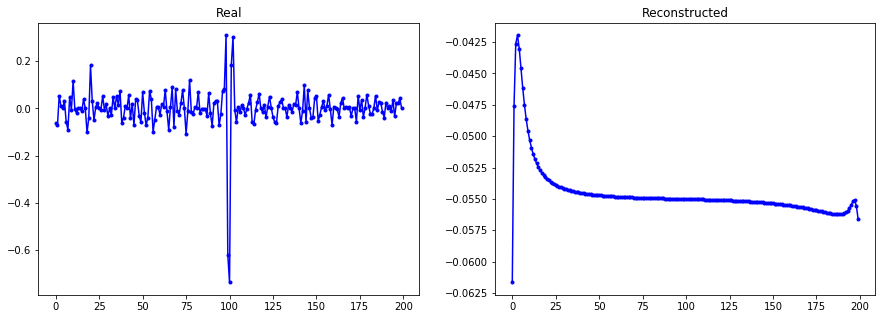

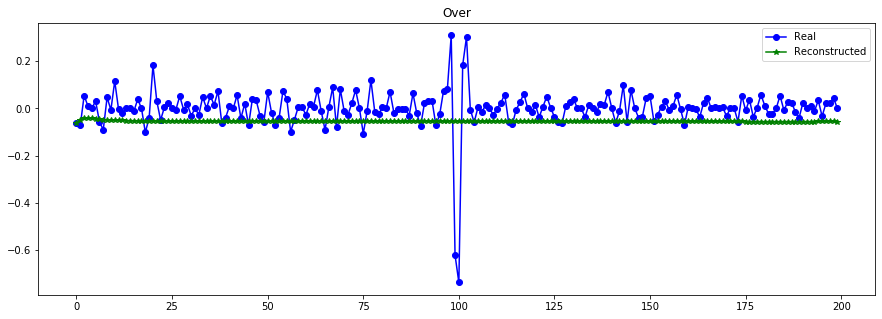

----------------------------------------------------------------


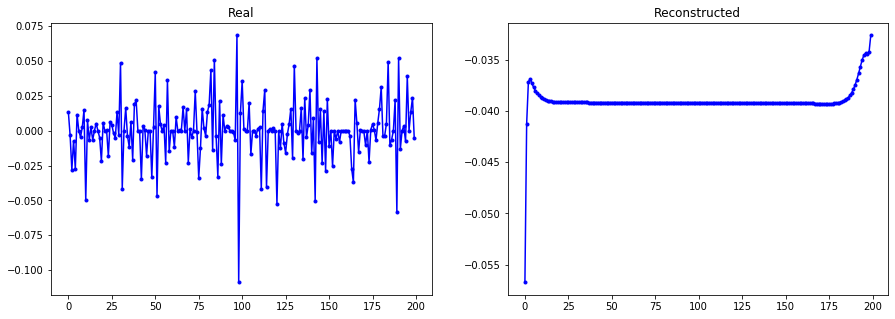

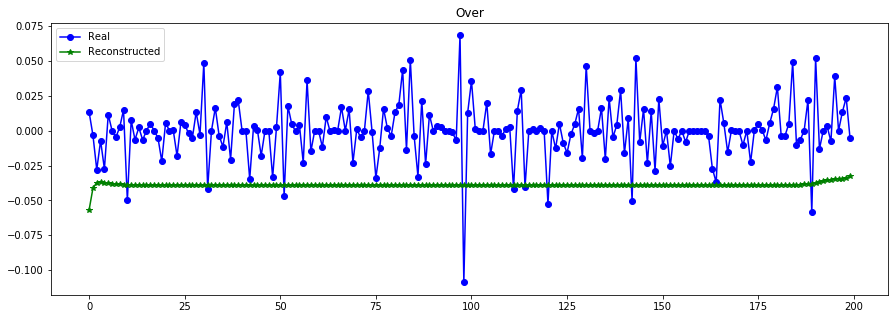

----------------------------------------------------------------


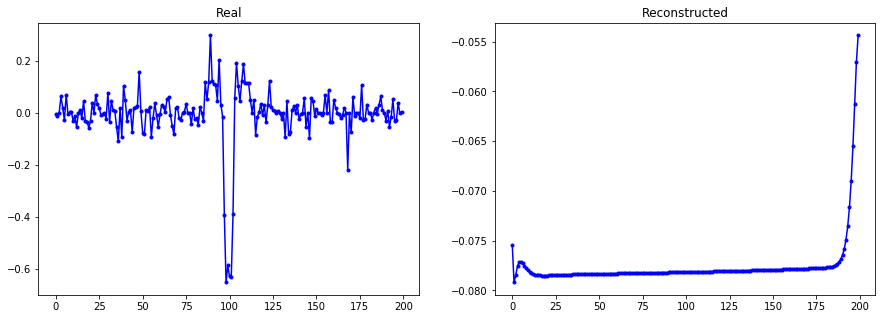

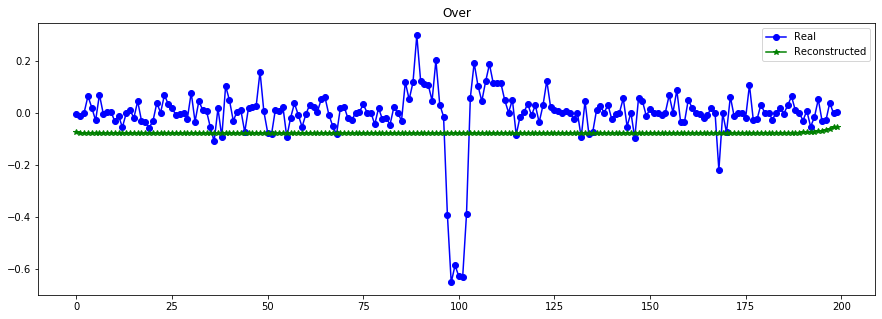

----------------------------------------------------------------


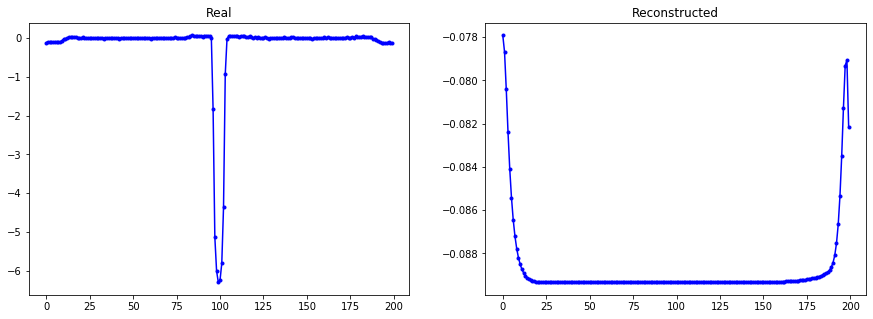

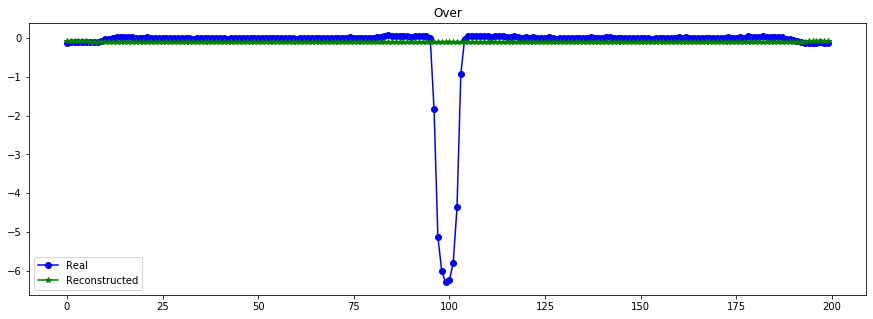

----------------------------------------------------------------


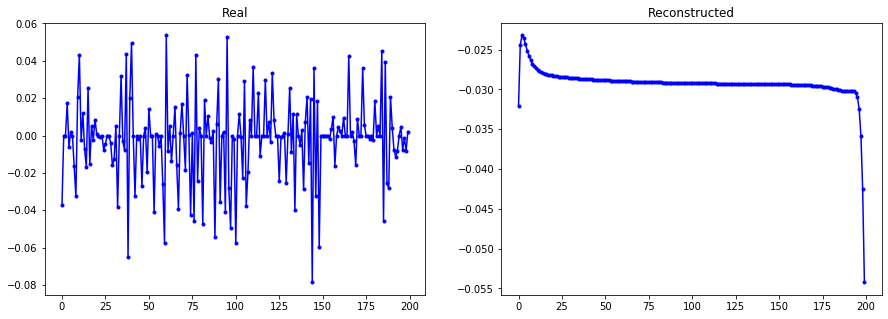

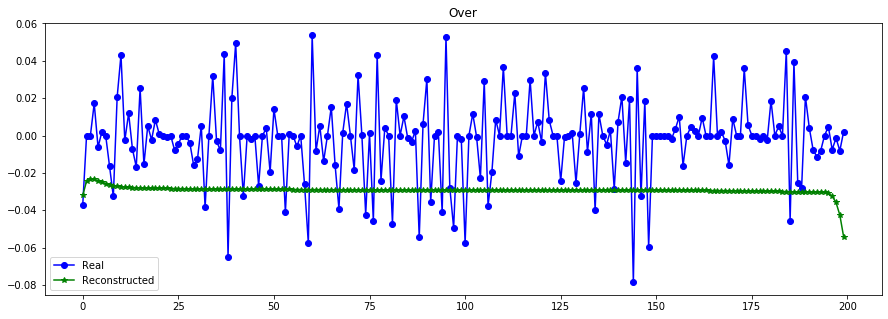

----------------------------------------------------------------


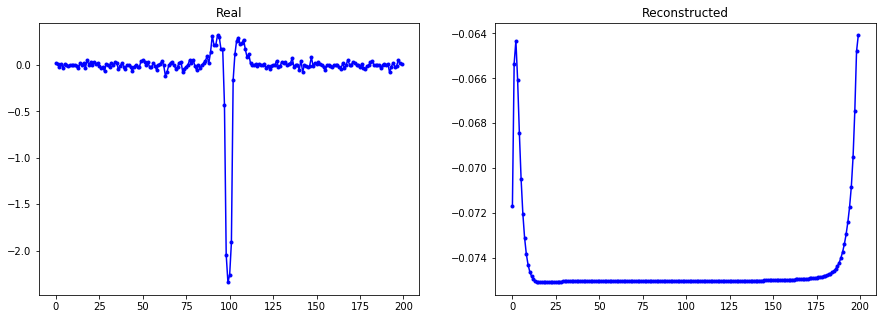

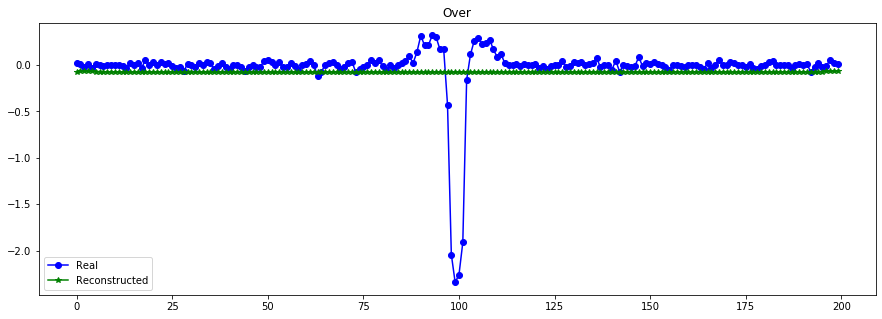

----------------------------------------------------------------


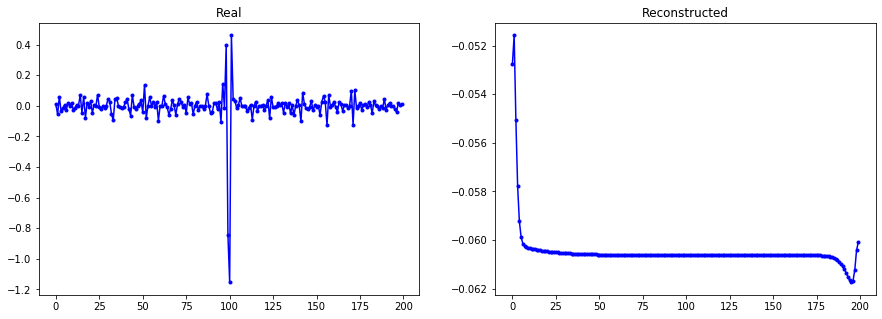

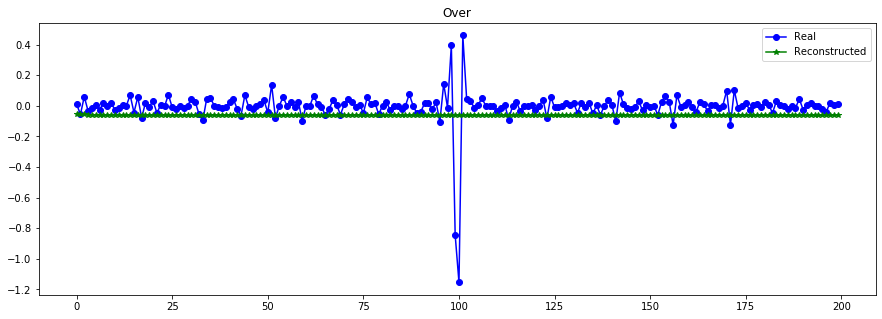

----------------------------------------------------------------


In [24]:
X_train_hat = vae.predict([X_train_t,X_train], batch_size=512)
plot_n_lc(X_train, X_train_hat, n= 10)

In [ ]:
## probar como el pato con funciones "seno" o coseno para ver si el modelo de verdad genera...

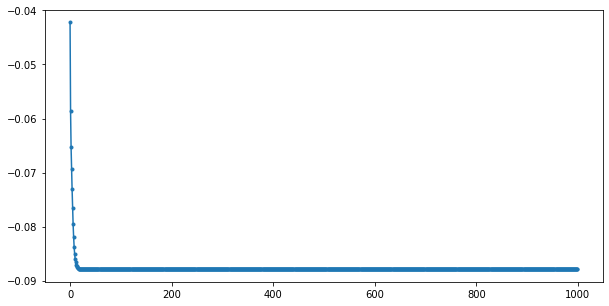

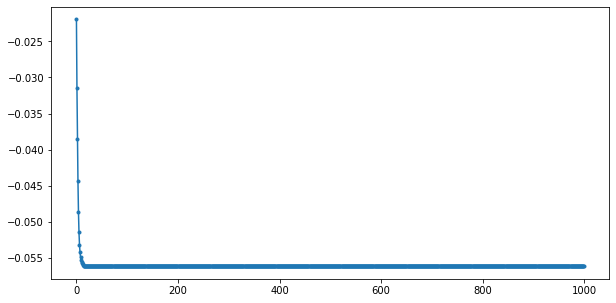

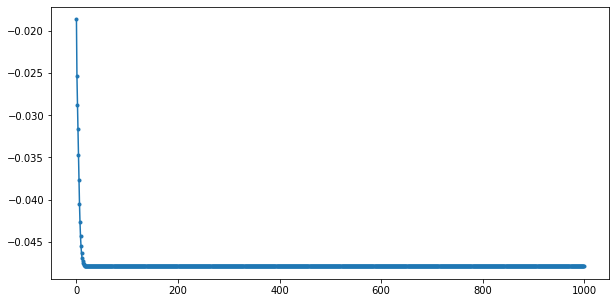

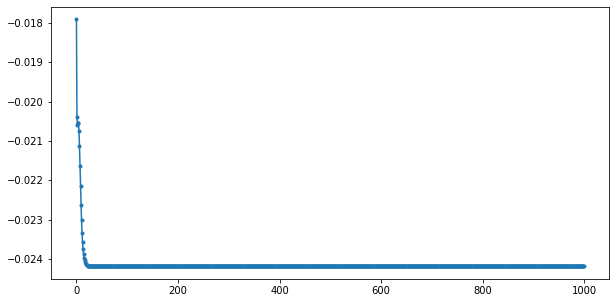

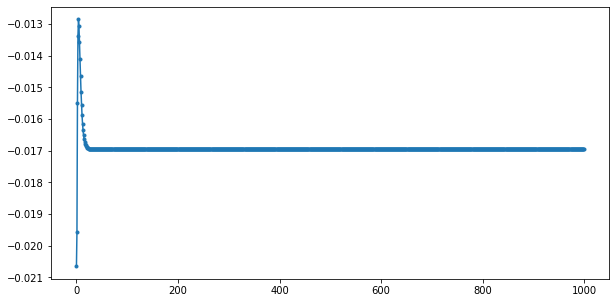

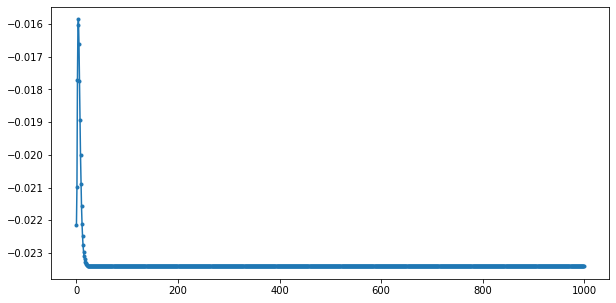

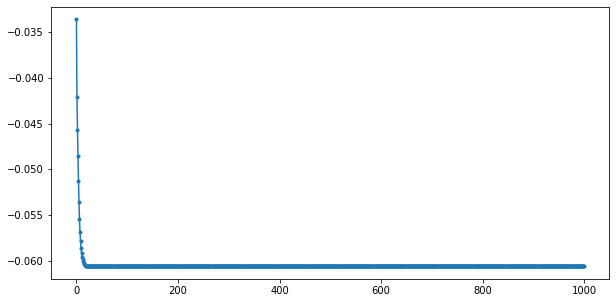

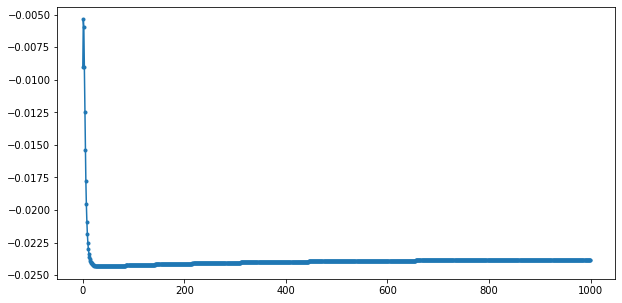

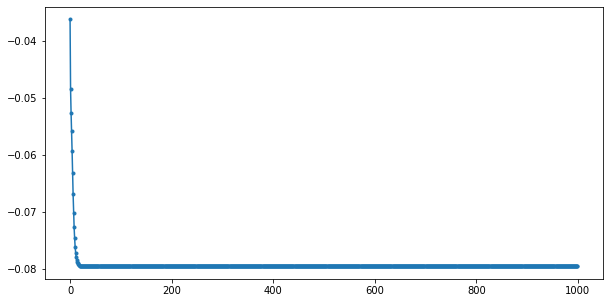

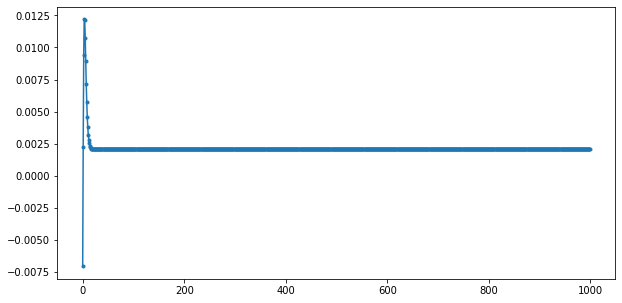

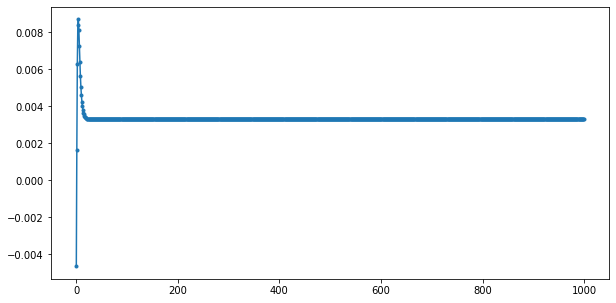

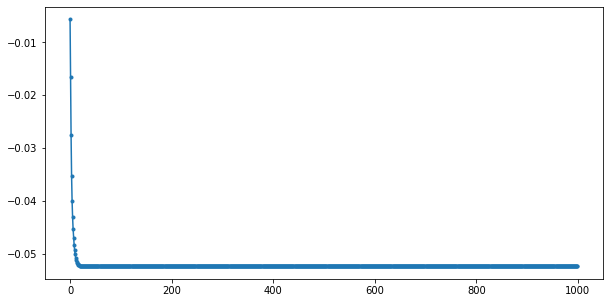

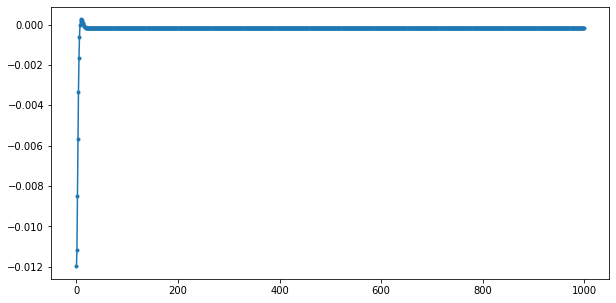

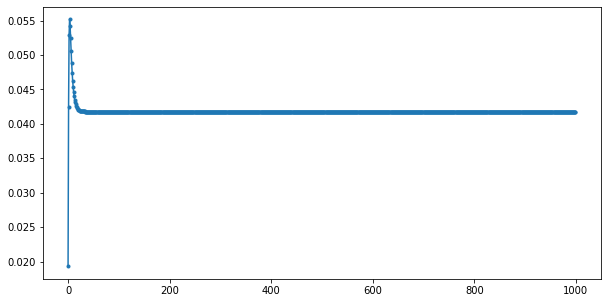

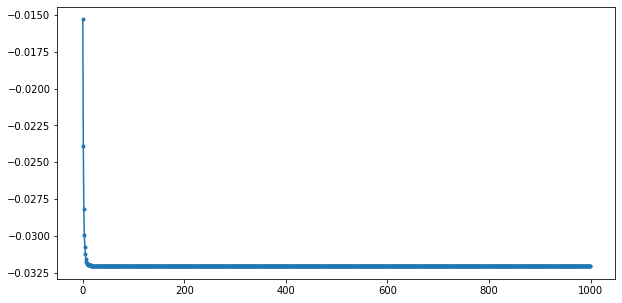

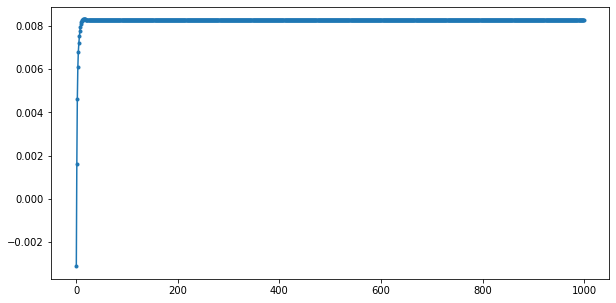

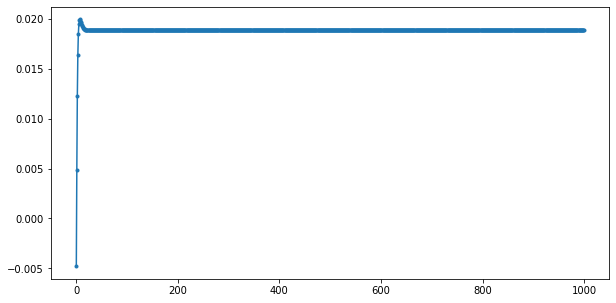

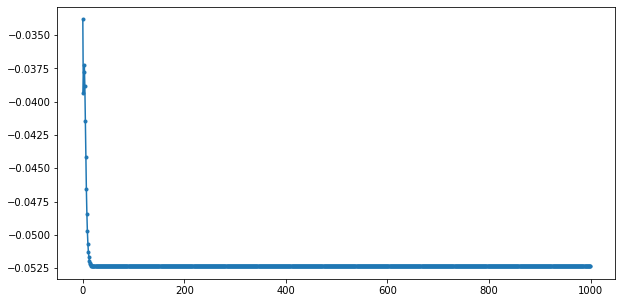

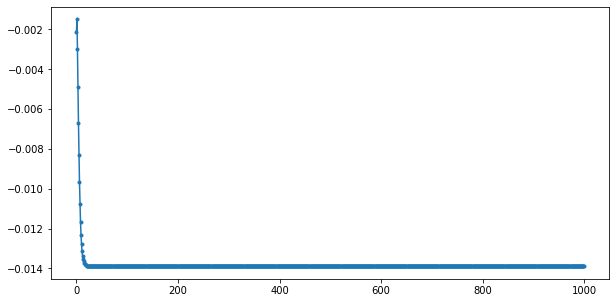

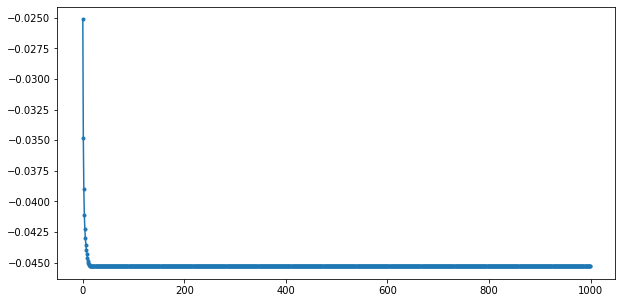

In [140]:
## generate random
n = 20

z_sampleds = np.random.normal(0, 1, size=(n,latent_dim))

x_decoded = generator.predict(z_sampleds)

for i in range(n):
    plt.figure(figsize=(10,5))
    plt.plot(x_decoded[i,:,0], '.-')
    plt.show()

## CONDITIONAL VAE

In [ ]:
cond = Input(input_shape=(D_dim,))


In [ ]:
inputs = merge([X, cond], mode='concat', concat_axis=1) #en el encoder..


In [ ]:
z_cond = merge([z, cond], mode='concat', concat_axis=1) # <--- NEW! #o en el decode (RNN)

In [ ]:
#for generator
d_z = Input(shape=(latent_dim,))
d_cond = Input(shape=(D_dim,))
d_inputs = merge([d_z, d_cond], mode='concat', concat_axis=1)


## Semi-Supervised VAE

In [ ]:
### data augmentation with mandel-agol